In [15]:
import os
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:  # detect if notebook is running on Kaggle
    !pip install gymnasium[atari]==1.1.0

In [39]:
from gymnasium.wrappers import Autoreset, TimeAwareObservation, FrameStackObservation, AtariPreprocessing, ClipReward
from collections import defaultdict, deque
from IPython.display import clear_output
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
import random
import ale_py
import wandb
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

In [40]:
# globals
device = 'cuda' if torch.cuda.is_available() else 'cpu'
env_name = 'BreakoutNoFrameskip-v4'

In [41]:
def make_env(render_mode=None):
    env = gym.make(env_name, render_mode=render_mode, max_episode_steps=10_000)
    # env = TimeAwareObservation(env)
    env = Autoreset(env)  # TimeAwareObservation before Autoreset or else timestep tracking will be erroneous!!
    env = AtariPreprocessing(env)
    env = FrameStackObservation(env, 4)
    env = ClipReward(env, -1, 1)
    return env

In [42]:
class ActorCritic(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
        #   nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, ...)
            nn.Conv2d(4, 32, 8, 4),      # (m, 4, 84, 84) -> (m, 32, 20, 20)
            nn.SiLU(),
            nn.Conv2d(32, 64, 4, 2),     # (m, 32, 20, 20) -> (m, 64, 9, 9)
            nn.SiLU(),
            nn.Conv2d(64, 64, 3, 1),     # (m, 64, 9, 9) -> (m, 64, 7, 7)
            nn.SiLU(),
            nn.Flatten(),                # (m, 64, 7, 7) -> (m, 3136)
            nn.Linear(3136, 512),        # (m, 3136) -> (m, 512)
            nn.SiLU()
        )        
        self.policy_head = nn.Linear(512, 4)  # -> output (m, 4)
        self.value_head = nn.Linear(512, 1)   # -> output (m, 1)

    @staticmethod
    @torch.no_grad()
    def preprocess(x):
        if len(x.size()) == 3:
            x = x.unsqueeze(0)  # add the batch dim
        x = x / 255.0  # should we scale to [0, 1]
        return x

    def value_only(self, x):
        x = self.preprocess(x)
        x = self.backbone(x)
        value = self.value_head(x)
        return value
        
    def forward(self, x):
        x = self.preprocess(x)
        x = self.backbone(x)
        logits = self.policy_head(x)
        value = self.value_head(x)
        
        return logits, value

    def sample(self, state, stochastic=True):
        logits, value = self.forward(state)
        dist = Categorical(logits=logits)
        if stochastic:
            action = dist.sample()
        else:
            action = torch.argmax(logits, dim=-1)
        log_prob = dist.log_prob(action)
        
        return action, log_prob, value
        

In [43]:
def scope():  # check env is set up correctly
    e = make_env()
    e.reset()
    for i in range(500):
        if i % 10 == 0:
            clear_output(wait=True)
        s, r, term, trunc, _ = e.step(e.action_space.sample())
        print('iter', i, (r,term,trunc))
        if term or trunc:
            sout = ''
            if term: sout += 'terminated'
            if trunc: sout += 'truncated'  # truncates at max_episode_steps
            print(sout)
    e.close()
scope()

iter 490 (np.float64(0.0), False, False)
iter 491 (np.float64(0.0), False, False)
iter 492 (np.float64(0.0), False, False)
iter 493 (np.float64(0.0), False, False)
iter 494 (np.float64(0.0), False, False)
iter 495 (np.float64(0.0), False, False)
iter 496 (np.float64(0.0), False, False)
iter 497 (np.float64(0.0), False, False)
iter 498 (np.float64(0.0), False, False)
iter 499 (np.float64(0.0), False, False)


In [44]:
@torch.no_grad()
def collect_rollout(env, network: ActorCritic, min_steps):
    states, actions, rewards, terminateds, truncateds, log_probs, values = [], [], [], [], [], [], []
    state = torch.as_tensor(env.reset()[0], dtype=torch.float).to(device)
    step = 0
    while True:
        step += 1
        action, log_prob, value = network.sample(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = torch.as_tensor(next_state, dtype=torch.float).to(device)
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        terminateds.append(terminated)
        truncateds.append(truncated)
        log_probs.append(log_prob)
        values.append(value)
        state = next_state
        if step >= min_steps and (terminated or truncated):
            break
    values.append(network.value_only(state))  # add the last value, we now have T+1 values in total
        
    states = torch.stack(states)                                                  # [T, |s|], |s| = dimension of the state vector
    actions = torch.stack(actions).reshape(step, -1)                              # [T, |a|], |a| = dimension of the action vector
    rewards = torch.as_tensor(rewards, dtype=torch.float).reshape(-1, 1).to(device)          # [T, 1]
    terminateds = torch.as_tensor(terminateds, dtype=torch.float).reshape(-1, 1).to(device)  # [T, 1]
    truncateds = torch.as_tensor(truncateds, dtype=torch.float).reshape(-1, 1).to(device)    # [T, 1]
    log_probs = torch.stack(log_probs).reshape(-1, 1)                             # [T, 1]
    values = torch.stack(values)                                                  # [T+1, 1], T = num_steps
    values = values.reshape(-1, 1)  # remove extra 1 dims at end
    
    return states, actions, rewards, terminateds, truncateds, log_probs, values

In [45]:
@torch.no_grad()
def evaluate(network: ActorCritic, stochastic=False, render_mode=None, graph=False):
    _env = make_env(render_mode)
    state = torch.as_tensor(_env.reset()[0], dtype=torch.float).to(device)
    sum_rewards = 0
    if graph:
        values = []
        immediate_reward = []
        rewards_collected = []
        values_plus_rewards = []
    step = 0
    while True:
        step += 1
        action, log_prob, value = network.sample(state, stochastic=stochastic)
        next_state, reward, terminated, truncated, _ = _env.step(action)
        sum_rewards += reward
        if graph:
            values += [value.item()]
            immediate_reward += [reward]
            rewards_collected += [sum_rewards]
            values_plus_rewards += [value.item() + sum_rewards - reward]
            if step % 20 == 0 or terminated or truncated:
                plt.plot(values, label='values')
                plt.plot(immediate_reward, label='immediate reward')
                plt.plot(rewards_collected, label='rewards collected')
                plt.plot(values_plus_rewards, label='rewards + values')
                plt.legend()
                clear_output(wait=True)
                plt.show()
        state = torch.as_tensor(next_state, dtype=torch.float).to(device)
        if terminated or truncated:
            break
    _env.close()
    return sum_rewards

In [46]:
def gae(rewards, terminateds, truncateds, values, gamma, lambda_):
    dones = torch.max(terminateds, truncateds)  # also reset gae on truncation
    td_errors = rewards + gamma * values[1:] * (1 - dones) - values[:-1]  # TD-errors = TD-targets - V(s)
    advantages = torch.zeros_like(td_errors)
    advantage = 0
    for t in reversed(range(len(td_errors))):
        advantage = lambda_ * gamma * advantage * (1 - dones[t]) + td_errors[t]    # gamma is being applied twice to discount far away TD-errors
        advantages[t] = advantage                                                  # also note (1 - terminateds[t]) is absolutely critical
        
    return advantages  # [T, 1], once trained, advantages should be close to 0

In [47]:
def explained_variance(returns, values):  # measure of critic's accuracy: 0 = random guessing, 1 = perfect
    var_returns = torch.var(returns)
    var_residuals = torch.var(returns - values)
    if var_returns == 0: return 0.0 if var_residuals == 0 else -float('inf')
    return (1 - var_residuals / var_returns).item()

In [48]:
batch_size = 512
num_steps = 4096  # steps per rollout
num_epochs = 10   # epochs per iteration
gae_lambda = 0.95      # GAE(lambda): 0 is same as TD-error, 1 is same as Monte Carlo return
value_weight = 0.5     # weight of value loss (vs policy loss)
entropy_bonus = 0.01 * 1.0  # entropy regularization coefficient in loss, may need to manually adjust with reward scale
clip_eps = 0.2         # policy ratio clipping radius
clip_eps_value = None   # value clipping radius
gamma = 0.99
policy_lr = 3e-4
value_lr = 1e-3
backbone_lr = 3e-4  # lr for the shared backbone, OpenAI's Spinning Up implicity uses same lr as critic
max_norm = 0.5

checkpoint_freq = 20
eval_freq = 2

In [49]:
try: env.reset(), env.close()
except: pass
env = make_env()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

network = ActorCritic().to(device)

# if compiling
# import cl_fix
# network = torch.compile(network)

shared_backbone_params = list(network.backbone.parameters())
policy_head_params = list(network.policy_head.parameters())
value_head_params = list(network.value_head.parameters())

optimizer = torch.optim.Adam([  # single optimizer, avoids ambiguity in lr of backbone that is present in Spinning Up
    {'params': policy_head_params, 'lr': policy_lr},
    {'params': value_head_params, 'lr': value_lr},
    {'params': shared_backbone_params, 'lr': backbone_lr},
])

wandb.finish()
wandb.init(
    project='PPO-' + env_name.replace('/', '_') + ' (discrete)',
    name='cpu test run',
    # mode='disabled',
    config={
        'batch_size': batch_size,
        'num_steps': num_steps,
        'num_epochs': num_epochs,
        'max_norm': max_norm,
        'gae_lambda': gae_lambda,
        'value_weight': value_weight,
        'entropy_bonus': entropy_bonus,
        'clip_eps': clip_eps,
        'clip_eps_value': clip_eps_value,
        'gamma': gamma,
        'policy_lr': policy_lr,
        'value_lr': value_lr,
        'backbone_lr': backbone_lr,
        'env_name': env_name,
        'device': device,
    }
)

history = {'step_count': 0}

In [50]:
# load
checkpoint = ''

In [51]:
def save(network, history):
    os.makedirs('saved', exist_ok=True)
    data = {
        'network_state_dict': network.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history
    }
    name = './saved/breakout-' + str(history['step_count']) + 's.pth'
    torch.save(data, name)
    print('saved to ' + name)

In [52]:
def train(env, num_updates, history):
    t_start = time.time()
    try:
        for update in range(1, num_updates+1):
            if update % checkpoint_freq == 0:
                save(network, history)
            
            t0 = time.time()
            states, actions, rewards, terminateds, truncateds, log_probs, values = collect_rollout(env, network, num_steps) 
            rollout_time = time.time() - t0
            
            t0 = time.time()
            gae_advantages = gae(rewards, terminateds, truncateds, values, gamma, gae_lambda)
            # advantages = (gae_advantages - gae_advantages.mean()) / (gae_advantages.std() + 1e-7)  # careful with standardization
            advantages = gae_advantages
            returns = values[:-1] + advantages  # discounted rewards-to-go
            actual_steps = len(states)  # actual steps taken 
            
            # stats across all minibatches
            mb_policy_losses = []
            mb_value_losses = []
            mb_entropies = []
            mb_kls = []
            mb_clip_fractions = []
            mb_global_l2_norms = []
            
            for _ in range(num_epochs):
                indices = torch.randperm(actual_steps)
                for begin in range(0, actual_steps, batch_size):
                    end = begin + batch_size
                    batch_indices = indices[begin:end]
                    
                    states_b = states[batch_indices]
                    actions_b = actions[batch_indices]
                    returns_b = returns[batch_indices]
                    advantages_b = advantages[batch_indices]
                    old_log_probs = log_probs[batch_indices]
                    
                    logits, values_b = network(states_b)
                    dist = Categorical(logits=logits)
                    entropy = dist.entropy().mean()
                    cur_log_probs = dist.log_prob(actions_b.squeeze()).reshape(old_log_probs.shape)
                
                    # policy loss
                    ratio = torch.exp(cur_log_probs - old_log_probs)  # same as cur_probs/old_probs, just with logs
                    fst_surrogate = ratio * advantages_b
                    snd_surrogate = torch.clip(ratio, 1 - clip_eps, 1 + clip_eps) * advantages_b
                    policy_loss = -torch.min(fst_surrogate, snd_surrogate).mean() - entropy_bonus * entropy
                    
                    # value loss
                    if clip_eps_value is not None:
                        old_values_b = values[batch_indices]
                        values_clipped = old_values_b + (values_b - old_values_b).clip(-clip_eps_value, clip_eps_value)
                        fst_loss = F.huber_loss(values_clipped, returns_b, reduction='none')
                        snd_loss = F.huber_loss(values_b, returns_b, reduction='none')
                        value_loss = value_weight * torch.max(fst_loss, snd_loss).mean()  # take the more conservative one
                    else:
                        value_loss = value_weight * F.huber_loss(values_b, returns_b, reduction='mean')
    
                    cum_loss = policy_loss + value_loss
                    optimizer.zero_grad()
                    cum_loss.backward()
                    global_l2_norm = nn.utils.clip_grad_norm_(network.parameters(), max_norm)
                    optimizer.step()
                    
                    # Track statistics for this minibatch
                    mb_policy_losses.append(policy_loss.item())
                    mb_value_losses.append(value_loss.item())
                    mb_entropies.append(entropy.item())
                    mb_kls.append((old_log_probs - cur_log_probs).mean().item())
                    clip_fraction = ((ratio > 1 + clip_eps) | (ratio < 1 - clip_eps)).float().mean().item()
                    mb_clip_fractions.append(clip_fraction)
                    mb_global_l2_norms.append(global_l2_norm)
                    
            # average stats across minibatches
            avg_policy_loss = sum(mb_policy_losses) / len(mb_policy_losses)
            avg_value_loss = sum(mb_value_losses) / len(mb_value_losses)
            avg_entropy = sum(mb_entropies) / len(mb_entropies)
            avg_kl = sum(mb_kls) / len(mb_kls)
            avg_clip_fraction = sum(mb_clip_fractions) / len(mb_clip_fractions)
            avg_global_l2_norm = sum(mb_global_l2_norms) / len(mb_global_l2_norms)
            
            history['step_count'] += actual_steps        
            
            update_time = time.time() - t0
            wall_time = time.time() - t_start
    
            t0 = time.time()
            with torch.no_grad():
                exp_var = explained_variance(returns, values[:-1])
            stats_time = time.time() - t0
                
            log = {
                'entropy': avg_entropy,
                'explained_variance': exp_var,
                'loss_policy': avg_policy_loss,  # entropy bonus incl.
                'loss_value': avg_value_loss,
                'loss_entropy': -entropy_bonus * avg_entropy,
                'loss_cum': avg_policy_loss + avg_value_loss,
                'approx_kl': avg_kl,  # average across all minibatches
                'clip_fraction': avg_clip_fraction,  # (policy ratio)
                'global_l2_norm': avg_global_l2_norm,
                'advantage': gae_advantages.mean().item(),  # pre standardization
                'update': update,
                'step_count': history['step_count'],
                'approx_fps': actual_steps / (update_time + rollout_time),
                'time_wall': wall_time,
                'time_update': update_time,
                'time_rollout': rollout_time,
                'time_stats': stats_time,
            }
    
            if update % eval_freq == 0 or update == num_updates:
                t0 = time.time()
                eval_rewards_d = evaluate(network, stochastic=False)
                eval_rewards_s = evaluate(network, stochastic=True)
                eval_time = time.time() - t0
                log.update({
                    'eval_time': eval_time,
                    'eval_rewards (deterministic)': eval_rewards_d,
                    'eval_rewards (stochastic)': eval_rewards_s,
                })
    
                clear_output(wait=True)
                print(f'wall time {wall_time:.2f} s')
                print(f'update {update}')
                print(f'step {history["step_count"]}')
                print(f'eval rewards (deterministic) {eval_rewards_d:.5f}')
                print(f'eval rewards (stochastic) {eval_rewards_s:.5f}')
    
            try: wandb.log(log)
            except: print(f'[warning] wandb log failed')

    except KeyboardInterrupt:
        save(network, history)

In [53]:
with torch.no_grad():
    np.set_printoptions(suppress=True, floatmode='fixed', precision=6)
    state, _ = env.reset()
    state = torch.as_tensor(state).to(device)
    logits, value = network(state)
    dist = Categorical(logits=logits)
    print(dist.probs.numpy(), dist.entropy().item())

    action, log_prob, value = network.sample(state)
    env.step(action)
    print(action)

[[0.244885 0.249089 0.258787 0.247239]] 1.3860719203948975
tensor([0])


In [54]:
try: env.reset(), env.close()
except: pass
env = make_env()

t0 = time.time()
try:
    with torch.device(device):
        train(env, 999999, history)
except KeyboardInterrupt:
        print('keyboard interrupt. stopping...')
finally:
    print(f'done.\n*actual* time taken: {time.time() - t0:.2f} s')

wall time 1022.63 s
update 8
step 33909
eval rewards (deterministic) 7.00000
eval rewards (stochastic) 0.00000
saved to ./saved/breakout-33909s.pth
done.
*actual* time taken: 1052.24 s


In [63]:
states, actions, rewards, terminateds, truncateds, log_probs, values = collect_rollout(env, network, 1) 
gae_advantages = gae(rewards, terminateds, truncateds, values, gamma, gae_lambda)
# advantages = (gae_advantages - gae_advantages.mean()) / (gae_advantages.std() + 1e-7)
advantages = gae_advantages
returns = values[:-1] + advantages  # discounted rewards-to-go
print(values.squeeze()[-9:], end='\n\n')  # no time step information hurts value estimation
print(returns.squeeze()[-9:])  # keep in mind standardization if done as well as time dependent obs

tensor([0.2389, 0.2780, 0.2814, 0.2889, 0.3236, 0.2715, 0.2541, 0.2485, 0.2230])

tensor([0.0881, 0.0811, 0.0716, 0.0613, 0.0500, 0.0361, 0.0241, 0.0123, 0.0000])


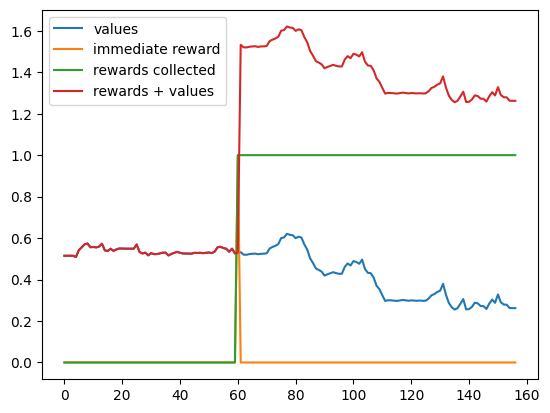

np.float64(1.0)

In [66]:
evaluate(network, stochastic=True, render_mode='human', graph=True)